['Beta' 'E484K' 'N501Y' 'Wuhan-Hu-1' 'Delta']
[331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402
 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420
 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438
 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531]
['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']


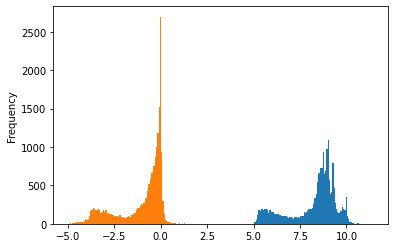

In [20]:
#Generate sequences for all mutations in deep mutational scan covid spike RBD experiment 
#! pip install Bio
import pandas as pd
import Bio
from Bio import SeqIO
from Bio import SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
#import tabulate

# read and get constants
url = 'https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/final_variant_scores/final_variant_scores.csv'
df = pd.read_csv(url) 

strains = df['target'].unique() # getting strain names from the df
pos = df['position'].unique()
aa = df['mutant'].unique()
plt.figure()
df['bind'].plot.hist(bins=100)
df['delta_bind'].plot.hist(bins=100)
print(strains)
print(pos)
print(aa)

In [4]:
#strains = ['Beta', 'E484K', 'N501Y', 'Wuhan-Hu-1', 'Delta']
# vectorized computation is preferable to iteration
# define functions:
def get_wt(df, strain_name): # get wt seq
    dfStrain = df.loc[(df['target'] == strain_name) & (df['wildtype'] == df['mutant']) ] # get wt aa's for a strain
    aa = dfStrain['wildtype'].str.cat() # cat a series to a string
    return(aa)

def get_binds(df): # get bind values, with ref+mutation as key (tuple)
    dict1 = df[['target', 'mutation', 'position', 'wildtype', 'mutant', 'bind', 'delta_bind']].to_dict('records')
    dict2 = {}
    for i in dict1:
        dict2[ (i['target'], i['mutation']) ] = {'bind': i['bind'], 
                                                 'd_bind': i['delta_bind'], 
                                                 'ref': i['target'],
                                                 'pos': i['position'],
                                                 'wt': i['wildtype'],
                                                 'mut': i['mutant']
                                                }
    return(dict2)
#print(get_binds(df, 20))    

In [5]:
# collect all info (seq, bind) in rowDict
wtSeq = {} # store wt as a dict so it could be matached to bind values
wtSeqRec = []
for strain in strains: 
    seqRec = SeqRecord(
        Seq(get_wt(df, strain)),
        id = strain + "_WT",
        )
    wtSeq[strain]= seqRec
    wtSeqRec.append(seqRec)
#print(wtSeq)
with open("wt.fas","w") as out_fh:
  SeqIO.write(wtSeqRec, out_fh, 'fasta')

rowDict = get_binds(df)
wtDict = {}
mutDict = {}
for rec in rowDict:
    #print(rowDict[rec])
    if rowDict[rec]['wt'] == rowDict[rec]['mut']: # wt
        rowDict[rec]['seq'] = wtSeq[rec[0]]
        wtDict[rec[0]] = rowDict[rec]
    else: # mutant
        sequence = MutableSeq(wtSeq[rec[0]].seq)
        #print(sequence)
        #print(type(int(rowDict[rec]['pos'] - pos[0])))
        sequence[int(rowDict[rec]['pos'] - pos[0]) ] = rowDict[rec]['mut']
        #print(sequence)
        rowDict[rec]['seq'] = SeqRecord(Seq(sequence), id = rec[1])
        mutDict[rec] = rowDict[rec]
print([ [x, wtDict[x]['bind']] for x in wtDict])

[['Beta', 9.3071], ['E484K', 8.96107], ['N501Y', 9.95503], ['Wuhan-Hu-1', 8.77161], ['Delta', 9.03525]]


['Beta', 'E484K', 'N501Y', 'Wuhan-Hu-1', 'Delta', 'Beta_E471A', 'Beta_Y501A', 'E484K_E471A', 'E484K_N501A', 'N501Y_E471A', 'N501Y_Y501A', 'Wuhan-Hu-1_E471A', 'Wuhan-Hu-1_N501A', 'Delta_E471A', 'Delta_N501A']
[('Beta', 'N501Y'), ('E484K', 'Beta'), ('Wuhan-Hu-1', 'E484K'), ('Wuhan-Hu-1', 'N501Y'), ('Wuhan-Hu-1', 'Delta'), ('Beta_E471A', 'Beta'), ('Beta_Y501A', 'Beta'), ('E484K_E471A', 'E484K'), ('E484K_N501A', 'E484K'), ('N501Y_E471A', 'N501Y'), ('N501Y_Y501A', 'N501Y'), ('Wuhan-Hu-1_E471A', 'Wuhan-Hu-1'), ('Wuhan-Hu-1_N501A', 'Wuhan-Hu-1'), ('Delta_E471A', 'Delta'), ('Delta_N501A', 'Delta')]


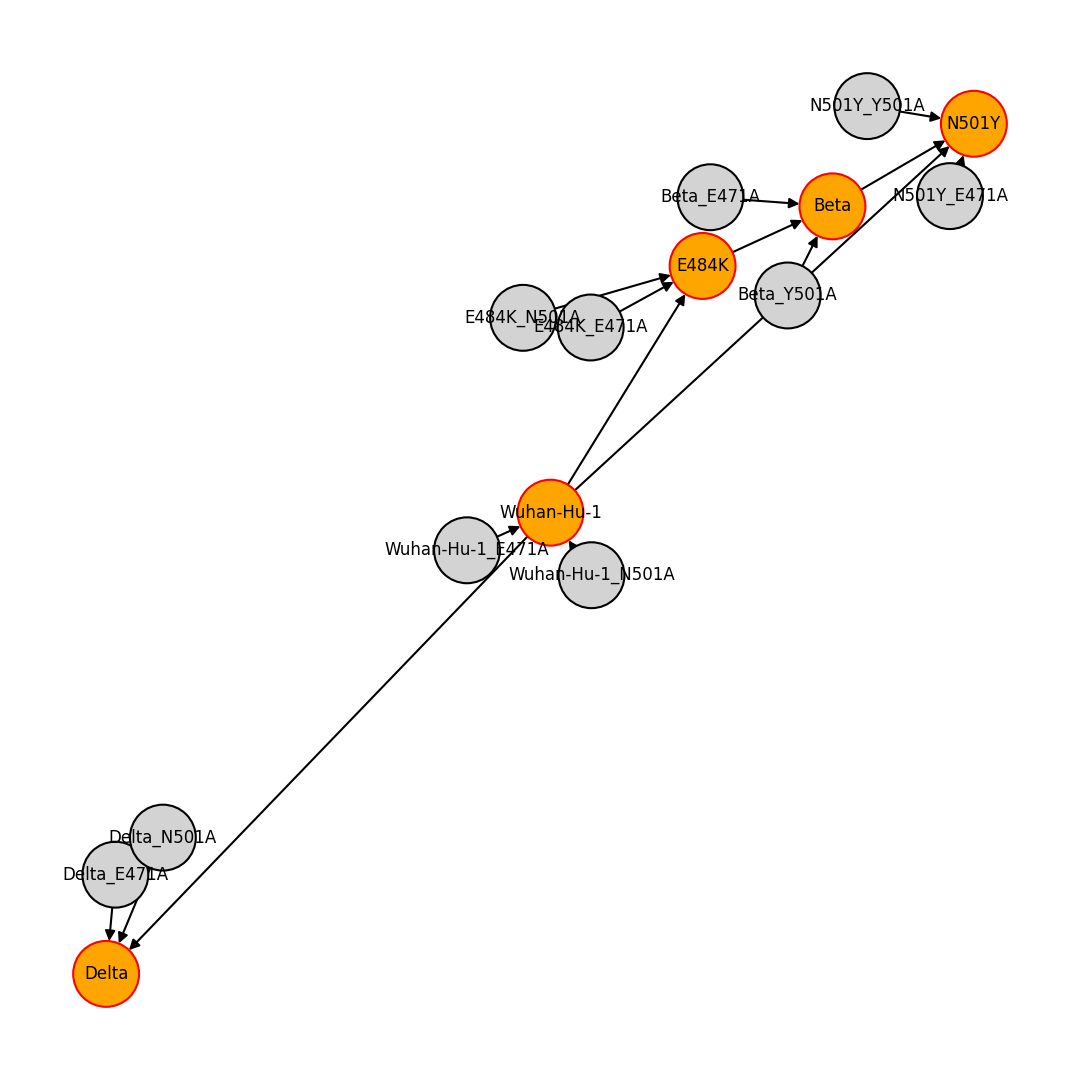

In [23]:
# build a directed graph
import networkx as nx

DG = nx.DiGraph() # a directed graph, there is lots of graph algorithms to identify local and global peaks; apply evol algo
for strain in wtDict: # add wt
    DG.add_node(strain) # add a node with a string name (id)
    for k in wtDict[strain]: # attach features: hap & fit 
        DG.nodes[strain][k] = wtDict[strain][k]

#pickSites = [417, 484, 501, 452, 478] # show these sites only
pickSites = [471, 501] # show these sites only
pickAAs = ['A']
pickRec = [ rec for rec in mutDict if (mutDict[rec]['pos'] in pickSites) & (mutDict[rec]['mut'] in pickAAs)  ]

for rec in pickRec: # add mut & edge
    id = rec[0] + "_" + rec[1]
    DG.add_node(id)
    for k in mutDict[rec]:
        DG.nodes[id][k] = mutDict[rec][k]

    if wtDict[rec[0]]['bind'] < mutDict[rec]['bind']: # higher bind for mut    
        DG.add_edge(rec[0], id)
    else:
        DG.add_edge(id, rec[0])
# add edges between WTs    
DG.add_edge(strains[3], strains[1]) # wuhan -> E484
DG.add_edge(strains[3], strains[2]) # wuhan -> N501
DG.add_edge(strains[1], strains[0]) # E484 -> beta
DG.add_edge(strains[0], strains[2]) # beta -> N501Y
DG.add_edge(strains[3], strains[4]) # wuhan -> delta
print(DG.nodes)
print(DG.edges)

plt.figure(figsize = (7,7), dpi=150)
nx.draw(DG, with_labels = True, 
        node_size = 1000,
        node_color = ['orange'] * 5 + ['lightgray'] * 10,
        edgecolors = ['red'] * 5 + ['black'] * 10,
        font_size = 8)
#plt.show()
plt.savefig("graph.png")
#print(DG.adj[strains[0]])
        


In [14]:
['red'] * 10 + ['black'] * 10

['red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black']